Epoch 1/6
261/261 [==============================] - 68s 215ms/step - loss: 0.3737 - accuracy: 0.8709 - precision: 0.9526 - recall: 0.8692 - val_loss: 2.9628 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/6
261/261 [==============================] - 55s 211ms/step - loss: 0.2173 - accuracy: 0.9109 - precision: 0.9681 - recall: 0.9099 - val_loss: 0.5726 - val_accuracy: 0.7154 - val_precision: 0.9958 - val_recall: 0.6197
Epoch 3/6
261/261 [==============================] - 54s 208ms/step - loss: 0.1687 - accuracy: 0.9341 - precision: 0.9789 - recall: 0.9312 - val_loss: 3.4300 - val_accuracy: 0.3212 - val_precision: 0.9853 - val_recall: 0.0868
Epoch 4/6
261/261 [==============================] - 55s 212ms/step - loss: 0.1525 - accuracy: 0.9346 - precision: 0.9777 - recall: 0.9333 - val_loss: 0.5088 - val_accuracy: 0.8058 - val_precision: 0.9965 - val_recall: 0.7409
Epoch 5/6
261/261 [==============================] - 56s 215ms/step - loss: 0.1376 - accuracy: 0

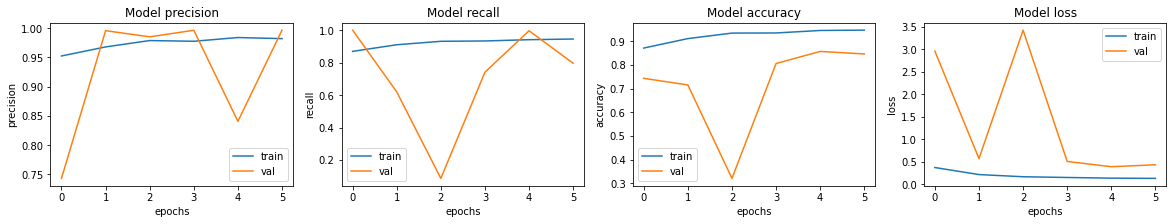

In [21]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')



# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]


# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 16
EPOCHS = 6


train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)


filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))


train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]


COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])


train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


# 데이터 좌우 반전 후 이미지와 레이블 반환 함수 
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label


def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 데이터 증강: 좌우 반전한 이미지 추가
    ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0


class_weight = {0: weight_for_0, 1: weight_for_1}


def conv_block(filters, kernel_size=3, strides=1):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])
    return block


def identity_block(x, filters):
    x_skip = x
    f1, f2 = filters

    x = conv_block(f1, kernel_size=1, strides=1)(x)
    x = conv_block(f1, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Conv2D(f2, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Identity + Feature
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.ReLU()(x)

    return x


def conv_block_with_skip(x, filters, strides):
    x_skip = x
    f1, f2 = filters

    x = conv_block(f1, kernel_size=1, strides=strides)(x)
    x = conv_block(f1, kernel_size=3, strides=1)(x)
    x = tf.keras.layers.Conv2D(f2, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut Conv
    x_skip = tf.keras.layers.Conv2D(f2, kernel_size=1, strides=strides, padding='same', use_bias=False)(x_skip)
    x_skip = tf.keras.layers.BatchNormalization()(x_skip)

    # Shorcut Conv + Feature
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.ReLU()(x)

    return x


def build_resnet_18():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Conv1
    x = conv_block(64, kernel_size=7, strides=2)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv2_x
    x = conv_block_with_skip(x, filters=(64, 256), strides=1)
    x = identity_block(x, filters=(64, 256))
    x = identity_block(x, filters=(64, 256))

    # conv3_x
    x = conv_block_with_skip(x, filters=(128, 512), strides=2)
    x = identity_block(x, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))

    # Conv4_x
    x = conv_block_with_skip(x, filters=(256, 1024), strides=2)
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))

    # Conv5_x
    x = conv_block_with_skip(x, filters=(512, 2048), strides=2)
    x = identity_block(x, filters=(512, 2048))
    x = identity_block(x, filters=(512, 2048))

    
    # Average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # FC
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


model = build_resnet_18()


METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)


history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight
)


fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()


for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')